# Environment setup

## Download code and data


In [1]:
!pip install imagecodecs tifffile

In [2]:
# Clone the GitHub repository and cd into it
!git clone 'https://github.com/CRefice/ml-segmentation-project.git'
%cd ml-segmentation-project/

fatal: destination path 'ml-segmentation-project' already exists and is not an empty directory.
/content/ml-segmentation-project


In [3]:
# Download the data using the fetch script
!./fetch-data.sh

Dataset already downloaded.


## Useful imports and settings

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from pathlib import Path
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision import transforms, datasets, models
import copy
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data

import unet
from dataset import CellSegmentationDataset


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data importing and massaging

Now we import the dataset and create train/test splitters.

In [5]:
BATCH_SIZE = 8
TRAIN_PERCENT = 0.8

img_transforms = transforms.Compose([
      # Convert to 0-1 float
      transforms.Lambda(lambda img: (img.astype(np.float32) - np.min(img)) / (np.max(img) - np.min(img))),  
      transforms.ToTensor(),
      transforms.CenterCrop(512),
])
target_transforms = transforms.Compose([
      transforms.Lambda(lambda img: img.astype(np.float32)),
      transforms.ToTensor(),
      # Limit to 0-1 for foreground-background segmentation
      transforms.Lambda(lambda img: img.clamp(max=1.0)),
      transforms.CenterCrop(512),
])

full_dataset = CellSegmentationDataset(raw_img_dir=Path("dataset/rawimages"),
                                  ground_truth_dir=Path("dataset/groundtruth"),
                                  pattern="normal",
                                  transform=img_transforms,
                                  target_transform=target_transforms,
                                )

train_size = int(len(full_dataset) * TRAIN_PERCENT)
test_size = len(full_dataset) - train_size

train_dataset, val_dataset = data.random_split(full_dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

# Training

In [6]:
model = unet.UNet().to(device)

In [7]:
summary(model, input_size=(1, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]             640
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256, 1

We first define the evaluation functions we'll be using during training.

In [8]:
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    

    intersection = (pred * target).sum(dim=2).sum(dim=2)
    
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    
    return loss.mean().item()

In [9]:
def evaluate(model, loader):
    n_val = len(loader)
    tot = 0
    for image, labels in loader:
        with torch.no_grad():
            pred = model(image.to(device))
            tot += dice_loss(pred, labels.to(device))
    return tot / n_val

In [16]:
def train_model(model, optimizer, criterion, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        since = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Training phase
        model.train()

        epoch_loss = 0
        epoch_dice_loss = 0
        epoch_samples = len(train_loader)
            
        torch.cuda.empty_cache()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)              
            # zero the parameter gradients
            optimizer.zero_grad()   
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()    
            epoch_loss += loss.item()
            epoch_dice_loss += dice_loss(outputs, labels)
        
        print("Epoch train loss: {}".format(epoch_loss / epoch_samples))
        print("Epoch dice loss: {}".format(epoch_dice_loss / epoch_samples))

        # Evaluation phase
        model.eval()
        val_loss = evaluate(model, val_loader)

        print("Epoch validation loss: {}".format(val_loss))

        time_elapsed = time.time() - since
        print('Took {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

In [17]:
TRN_EPOCHS = 20
WEIGHT_DECAY = 1e-4
LEARNING_RATE = 0.01
MOMENTUM = 0.99

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(model.parameters(), lr = LEARNING_RATE, momentum=MOMENTUM)
criterion = nn.BCELoss()
# Maybe interesting to use later
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

train_model(model, optimizer, criterion, exp_lr_scheduler, num_epochs=TRN_EPOCHS)

Epoch 0/29
----------
Epoch train loss: 0.5576139241456985
Epoch dice loss: 0.6767605990171432
Epoch validation loss: 0.7252253890037537
Took 0m 8s

Epoch 1/29
----------
Epoch train loss: 0.5314968824386597
Epoch dice loss: 0.6550986170768738
Epoch validation loss: 0.55475714802742
Took 0m 8s

Epoch 2/29
----------
Epoch train loss: 0.4667579084634781
Epoch dice loss: 0.5951192528009415
Epoch validation loss: 0.400170162320137
Took 0m 8s

Epoch 3/29
----------
Epoch train loss: 0.3158148005604744
Epoch dice loss: 0.4419495314359665
Epoch validation loss: 0.21334846317768097
Took 0m 8s

Epoch 4/29
----------
Epoch train loss: 0.15614867210388184
Epoch dice loss: 0.22792036831378937
Epoch validation loss: 0.11034925282001495
Took 0m 8s

Epoch 5/29
----------
Epoch train loss: 0.0999178346246481
Epoch dice loss: 0.0980449914932251
Epoch validation loss: 0.03843364119529724
Took 0m 8s

Epoch 6/29
----------
Epoch train loss: 0.2396396342664957
Epoch dice loss: 0.051379162818193436
Epoch v

# Generating predictions

We now generate predictions for one batch of data and compare it to the ground truth.

In [18]:
inputs, labels = next(iter(val_loader))
with torch.no_grad():
    outputs = model.predict(inputs.to(device))

<Figure size 432x288 with 0 Axes>

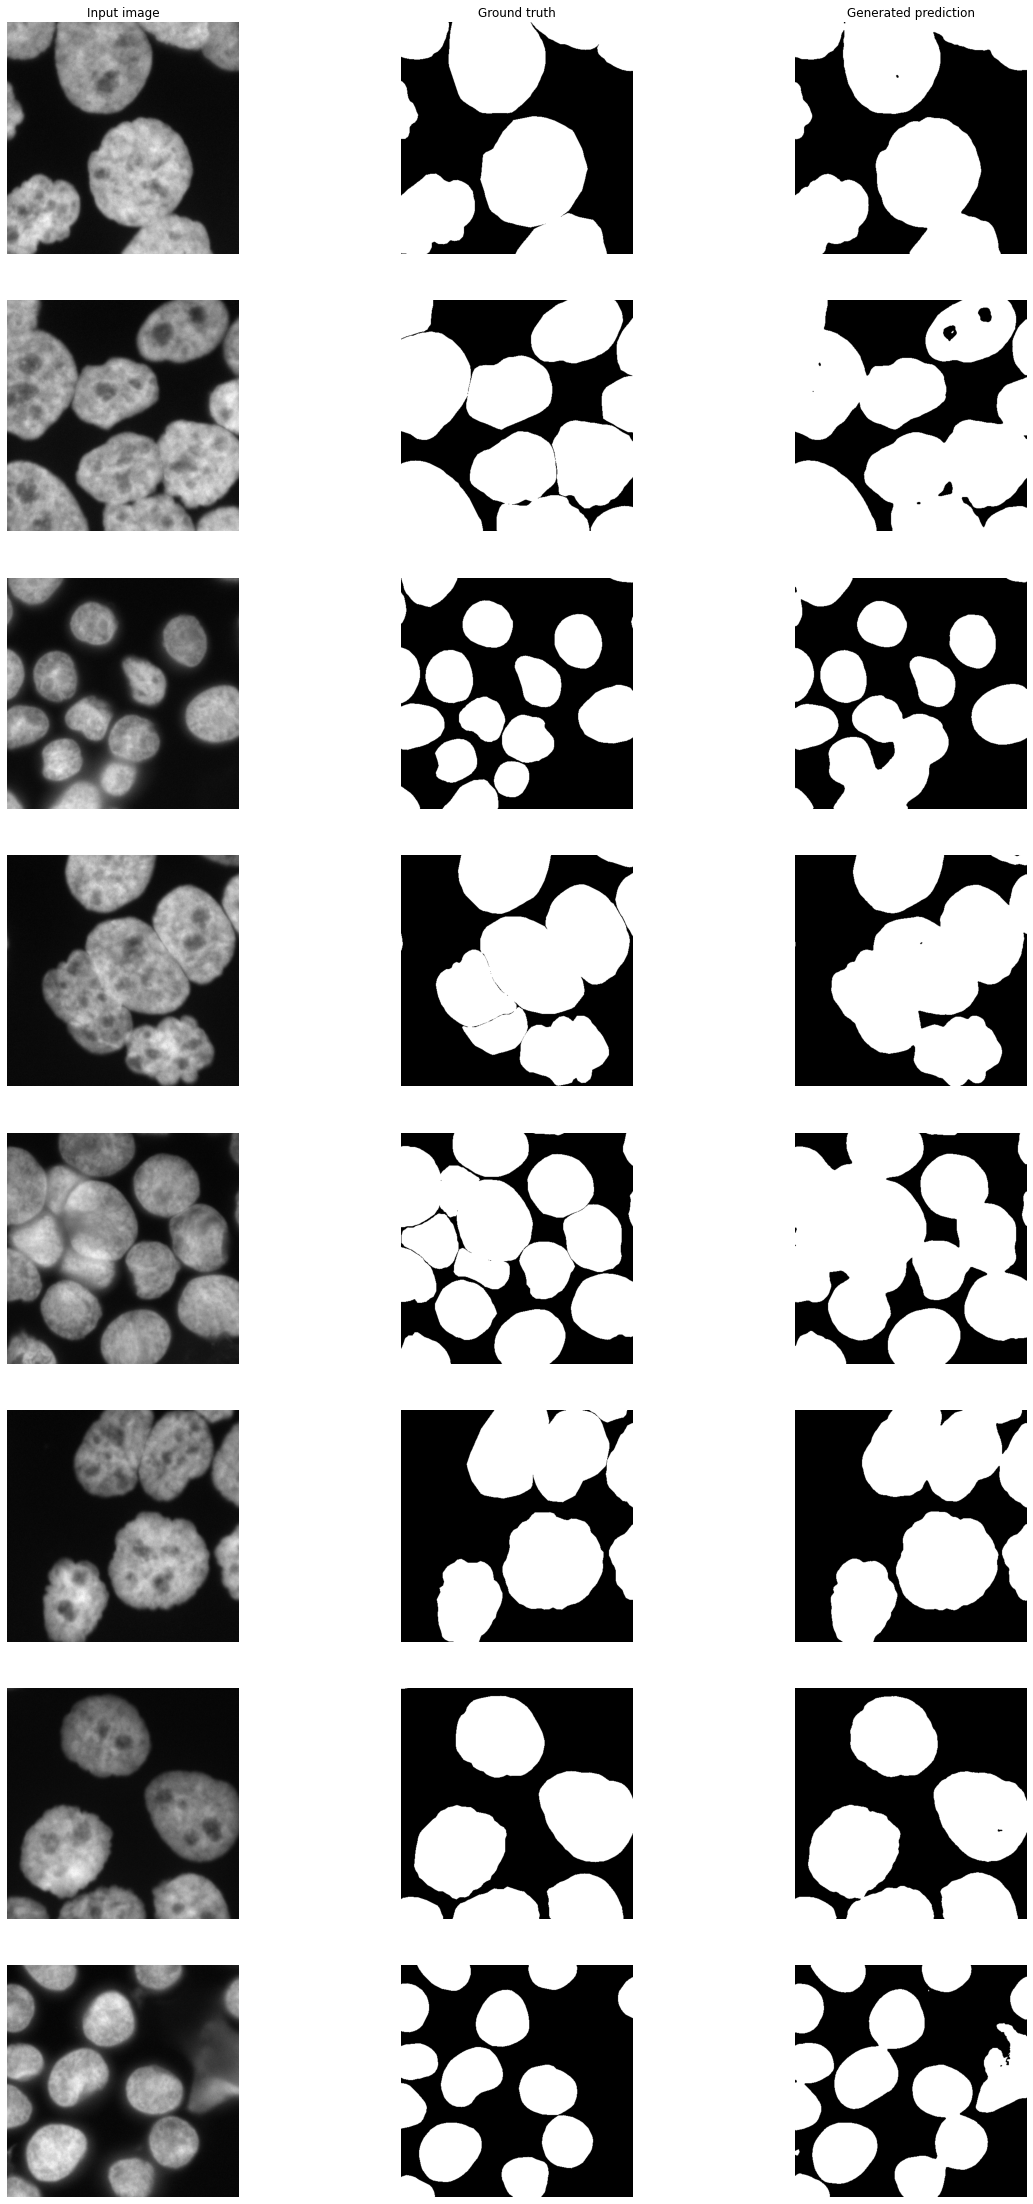

In [27]:
plt.gray()
fig = plt.figure(figsize=(20,40))
axs = fig.subplots(len(inputs), 3)

for ax in axs.flat:
    ax.axis("off")

column_labels = ["Input image", "Ground truth", "Generated prediction"]
for ax, label in zip(axs[0], column_labels):
    ax.set_title(label)

for i in range(len(inputs)):
    axs[i, 0].imshow(inputs[i].cpu().squeeze())
    axs[i, 1].imshow(labels[i].cpu().squeeze())
    axs[i, 2].imshow(outputs[i].cpu().squeeze())

fig.show()